# I limiti della Funzione di probabilità

La funzione di probabilità lavora bene se il numero di valori è piccolo, se il numero di valori aumenta la probabilità associata ad ogni uno diventa piccola e l'effetto del rumore aumenta.

Per esempio potremmo essere interessati alla distribuzione dei valori del peso del bebè. Nel nostro dataset la colonna da analizzare è la `totalwgt_lb` che misura il valore in libbre.

Il grafico qui sotto mostra i valori del primo bambino rispetto agli altri

In [1]:
from utils import readReadFemPreg

preg = readReadFemPreg()
live = preg[preg.outcome == 1]

firts = live[live.birthord == 1]
others = live[live.birthord > 1]

In [2]:
pfirst  = firts['totalwgt_lb'].value_counts(normalize=True).sort_index()
pothers = others['totalwgt_lb'].value_counts(normalize=True).sort_index()

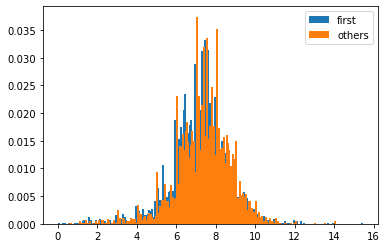

In [3]:
import matplotlib.pyplot as plt
import numpy as np
width = 0.1

fig, ax = plt.subplots()
ax.bar(pfirst.index - width/2,pfirst.values, width, label='first')
ax.bar(pothers.index + width/2,pothers.values, width, label='others')

plt.legend(loc='upper right')

Nel complesso queste distribuzioni ricordano la forma a campana di una distribuzione normale, con molti valori vicino alla media e pochi più alti e più bassi.

Ma parti di questa figura sono di difficile interpretazione, ci sono molti picchi e avvallamenti con alcune apparenti differenze tra le distribuzioni. 

È difficile dire quali di queste features siano significative, ed inoltre è difficile capire complessivamente i suo pattern.
Per esempio quale delle due distribizioni ha la media più alta ?

Questi problemi possono essere mitigati usando la tecnica del binning, dividendo i dati in bin con valori che non si sovrappongano ma quale è la dimensione giusta da dare a ciascuno?

Come alternativa si puo usare la funzione di ripartizione, prima di partire dobbiamo riprendere in mano il concetto di **percentile**.

## I percentili

Se si è mai fatto un test standardizzato probabilmente si è ricevuta ua risposta e un rango percentile. In questo contesto il rango percentile è la frazione di persone che hanno ricevuto un voto inferiore o uguale al tuo. Dunque se sei nel 90-esimo percentile il tuo voto è stato migliore o uguale del 90% delle persone che hanno eseguito il test.

Come si calcola il percentile lo abbiamo visto nella lezione precedente, la differenza tra percentile e rango percentile sta nel fatto che il rango percentile dato un valore calcola il percentile associato ad esso mentre nel percentile viene presto un rango percentile e come risultato si ha il percentile associato ad esso.

## La Funzione di ripartizione
Ora che sappiamo come funzionano i percentili e il rango percentile possiamo affrontare la funzione di ripartizione (CDF cumulative distribution function).
Questa funzione mappa un valore nel suo rango percentile, possiamo dire che la funzione CDF è una funzione di x dove per ogni x  valore della distribuzione si calcola la frazione di valori che sono minori o uguali ad x.

Se dovessimo scrivere in codice pyhton questa funzione dovrebbe prendere in ingresso la sequenza di valori t e il valore x

```pyhton
def evalCdf(t,x):
    count = 0.0
    for value in t:
        if value <= x:
            count += 1.0
    
    prob = count / len(t)
    
    return prob
 ```
 
Supponiamo di avere la sequenza di valori `[1, 2, 2, 2, 5]` la funzione di ripartizione avrà i seguenti risultati per i vari valori di x:

* CDF(0) = 0
* CDF(1) = 0.2
* CDF(2) = 0.6
* CDF(3) = 0.8
* CDF(4) = 0.8
* CDF(5) = 1

Possiamo valutare la funzione per ogni valore di x, non solo i valori presenti nel campione.
Se x è più piccolo del più piccolo valore del campione CDF(x) ha come valore 0 mentre se x è più grande del massimo valore del campione CDF(x) sarà 1.

La rappresentazione grafica del campione visto prima può essere rappresentato graficamente:

<BarContainer object of 7 artists>

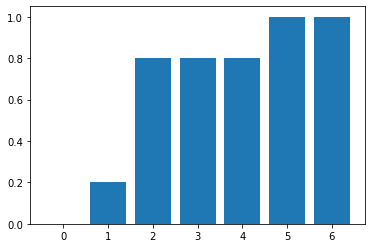

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

t = [1, 2, 2, 2, 5]

def evalCdf(t,x):
    count = 0.0
    for value in t:
        if value <= x:
            count += 1.0

    prob = count / len(t)

    return prob

d = {}
for x in range(max(t) + 2):
    d[x] = evalCdf(t,x)

plt.bar(d.keys(), d.values())

Utilizziamo ora pandas per rappresentare la funzione di ripartizione applicata al periodo di gestazione del dataset

In [5]:
import pandas as pd
stats_df = live.groupby('prglngth')['prglngth'].agg('count').pipe(pd.DataFrame).rename(columns = {'prglngth': 'frequency'})
stats_df['pmf'] = stats_df['frequency'] / sum(stats_df['frequency'])
stats_df['cdf'] = stats_df['pmf'].cumsum()
stats_df = stats_df.reset_index()

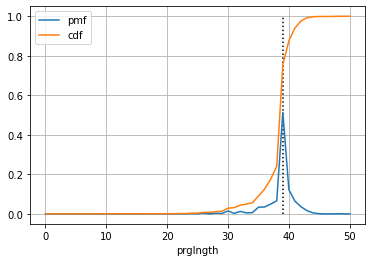

In [6]:
stats_df.plot(x = 'prglngth', y = ['pmf', 'cdf'], grid = True)
plt.vlines(39, 0, 1, linestyles ="dotted", colors ="k")

Un modo di leggere la funzione di ripartizione è cercare il percentile. A esempio sembra che il 10% delle gravidanze sia più corta di 36 settimane e circa il 90% delle gravidanze sia più corta di 41 settimane.

La funzione di ripartizione fornisce una rappresentazione visuale della forma della distribuzione. 
Un valore comune appare come un gradino, nell'esempio precendente si vede che la moda di 39 settembre e ci sono pochissimi valori sotto le 30 settimane e li il grafico si appiattisce.

## Comparare le distribuzioni 

La funzione di ripartizione è molto utile se dobbiamo confrontare delle distribuzione 

In [7]:
stats_df = firts.groupby('totalwgt_lb')['totalwgt_lb'].agg('count').pipe(pd.DataFrame).rename(columns = {'totalwgt_lb': 'frequency'})
stats_df['pmf'] = stats_df['frequency'] / sum(stats_df['frequency'])
stats_df['cdf'] = stats_df['pmf'].cumsum()
stats_df = stats_df.reset_index()

In [8]:
stats_dfo = others.groupby('totalwgt_lb')['totalwgt_lb'].agg('count').pipe(pd.DataFrame).rename(columns = {'totalwgt_lb': 'frequency'})
stats_dfo['pmf'] = stats_dfo['frequency'] / sum(stats_dfo['frequency'])
stats_dfo['cdf'] = stats_dfo['pmf'].cumsum()
stats_dfo = stats_dfo.reset_index()

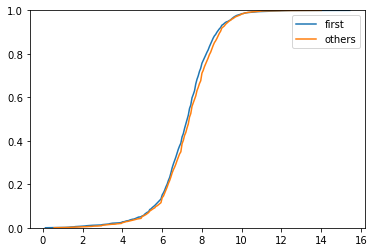

In [9]:
plt.plot(stats_df.totalwgt_lb,stats_df.cdf, label='first')
plt.plot(stats_dfo.totalwgt_lb,stats_dfo.cdf, label='others')

plt.ylim(0,1)
plt.legend(loc='upper right')

La figura sopra mostra il risultato della comparazione, possiamo vedere che il primo figlio tenda ad essere leggermente più leggero dei successivi. 


## Comparare i ranghi percentili

I ranghi percentili sono utili per comparare delle misure tra diversi gruppi.
Per esempio le persone che completano una gara di corsa sono raggruppate per età e sesso.

Per comparare le persone in differenti gruppi di età si possono convertire i tempi in ranghi percentili, per poi riportare il percentile dell'altro gruppo al valore desiderato.
